# **Sentiment Analysis of IMDb Movie Reviews**

### 1. Importing neccesary libraries

In [50]:
import pandas as pd
import re
import spacy
from spacy import displacy
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score


!pip install wordcloud
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 2. Loading of Dataset

In [51]:
df=pd.read_csv('/content/IMDB_Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 3. EDA + Text Preprocessing

In [52]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [53]:
df['sentiment']=df['sentiment'].map({'positive':1,'negative':0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [54]:
# removing html tags #
def remove_html_tags(text):
  """Remove html tags from a string"""
  clean = re.compile('<.*?>')
  return re.sub(clean, '', text)

df['review'] = df['review'].apply(lambda x: remove_html_tags(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [55]:
# implementation of spaCy - POS tagging #
nlp=spacy.load('en_core_web_sm')
text=df['review'][0]
text=nlp(text)

for token in text:
    if token.pos_ not in ["SPACE",'X','PUNCT']:
        print(token, '|------|', spacy.explain(token.pos_))

One |------| numeral
of |------| adposition
the |------| determiner
other |------| adjective
reviewers |------| noun
has |------| auxiliary
mentioned |------| verb
that |------| subordinating conjunction
after |------| adposition
watching |------| verb
just |------| adverb
1 |------| numeral
Oz |------| noun
episode |------| noun
you |------| pronoun
'll |------| auxiliary
be |------| auxiliary
hooked |------| verb
They |------| pronoun
are |------| auxiliary
right |------| adjective
as |------| subordinating conjunction
this |------| pronoun
is |------| auxiliary
exactly |------| adverb
what |------| pronoun
happened |------| verb
with |------| adposition
me |------| pronoun
The |------| determiner
first |------| adjective
thing |------| noun
that |------| pronoun
struck |------| verb
me |------| pronoun
about |------| adposition
Oz |------| proper noun
was |------| auxiliary
its |------| pronoun
brutality |------| noun
and |------| coordinating conjunction
unflinching |------| verb
s

In [56]:
# implementation of spaCy - NER tagging #
for ent in text.ents:
    print(ent.text, " | ", ent.label_, ' | ', spacy.explain(ent.label_))

One  |  CARDINAL  |  Numerals that do not fall under another type
just 1 Oz  |  PERCENT  |  Percentage, including "%"
the Oswald Maximum Security State Penitentary  |  ORG  |  Companies, agencies, institutions, etc.
Emerald City  |  GPE  |  Countries, cities, states
Aryans  |  NORP  |  Nationalities or religious or political groups
Muslims  |  NORP  |  Nationalities or religious or political groups
Latinos  |  ORG  |  Companies, agencies, institutions, etc.
Christians  |  NORP  |  Nationalities or religious or political groups
Italians  |  NORP  |  Nationalities or religious or political groups
Irish  |  NORP  |  Nationalities or religious or political groups
first  |  ORDINAL  |  "first", "second", etc.
Watching Oz  |  PERSON  |  People, including fictional


In [57]:
# use of displacy tool in NER tagging #
displacy.render(text,style='ent')

In [58]:
# further text preprocessing #

# lowercasing text data #

reviews = df['review']
corpus=[]

for i in range(0,len(df)):
    review = re.sub('[^a-zA-Z]', ' ', str(reviews[i]))
    review = review.lower()
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)

corpus[0:1]

['one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare forget pretty 

In [59]:
# dealing with stopwords #

df['review']=corpus
stop_words = set(stopwords.words('english'))
more_words=['film','movie'] # also removing certain common words that dont provide much meaning
stop_words.update(more_words)
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
corpus = df['review']
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


In [60]:
# top 50 most commmon words in corpus #

words_list = [word for line in corpus for word in line.split()]
word_counts = Counter(words_list).most_common(50)
words_df = pd.DataFrame(word_counts)
words_df.columns = ['word', 'frequency']
words_df.head()

,word,frequency
0,one,53585
1,like,40160
2,good,29737
3,time,25099
4,even,24856


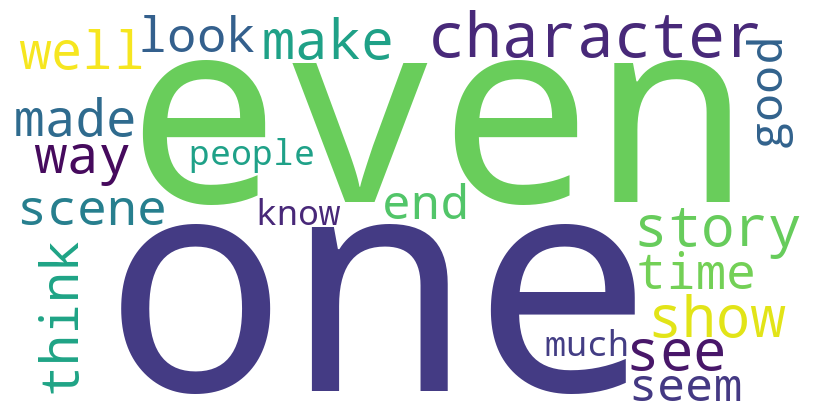

In [61]:
# implementation of word cloud visualisation #
text = " ".join(review for review in df['review'])
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=20).generate(text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 4. Data Preparation

In [62]:
# onto conversion of text to numerical representations #

# BoW - Statistical method, does not capture semantical meaning #
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()

In [63]:
y = np.array(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 5. Models Used

In [64]:
# VSA (Vader Sentiment Analyser) #
sid = SentimentIntensityAnalyzer()
def sentiment_Vader(text):
    over_all_polarity = sid.polarity_scores(text)
    if over_all_polarity['compound'] >= 0:
        return 1
    else:
        return 0
vad = pd.DataFrame(data = list(df['review'].apply(lambda x: sentiment_Vader(x)))) # text --> column name


# log regr #
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.1, solver='lbfgs').fit(X_train, y_train)

# naive bayes #
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB().fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
yhat = LR.predict(X_test)
yhat_nb = nb_model.predict(X_test)
df['VSA_label'] = vad

### 6. Evaluation Metrics

In [66]:
print("Accuracy (VADER) : ",accuracy_score(df['sentiment'],df['VSA_label']))
print("Accuracy (Logistic Regression) : ",accuracy_score(y_test,yhat))
print("Accuracy (Naïve Bayes) : ",accuracy_score(y_test,yhat_nb))

Accuracy (VADER) :  0.67284
Accuracy (Logistic Regression) :  0.8954
Accuracy (Naïve Bayes) :  0.8629


[[21688  3312]
 [13046 11954]]
Normalized confusion matrix
[[0.87 0.13]
 [0.52 0.48]]


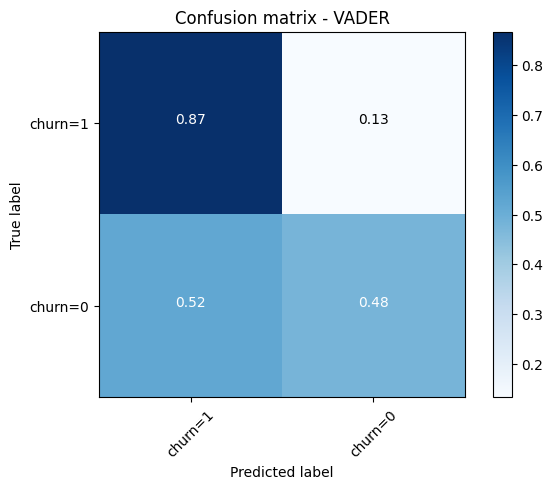

In [67]:
## confusion matrix ##
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(df['sentiment'],df['VSA_label'], labels=[1,0]))


# Compute confusion matrix
cnf_matrix = confusion_matrix(df['sentiment'],df['VSA_label'], labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= True,  title='Confusion matrix - VADER')

[[4547  492]
 [ 554 4407]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.11 0.89]]


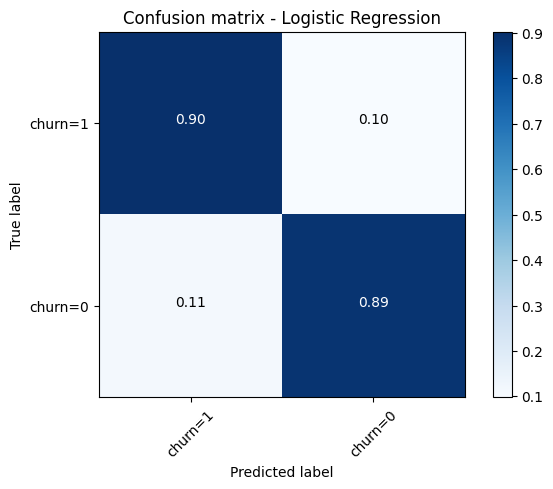

In [68]:
## confusion matrix ##
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test,yhat, labels=[1,0]))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= True,  title='Confusion matrix - Logistic Regression')

[[4265  774]
 [ 597 4364]]
Normalized confusion matrix
[[0.85 0.15]
 [0.12 0.88]]


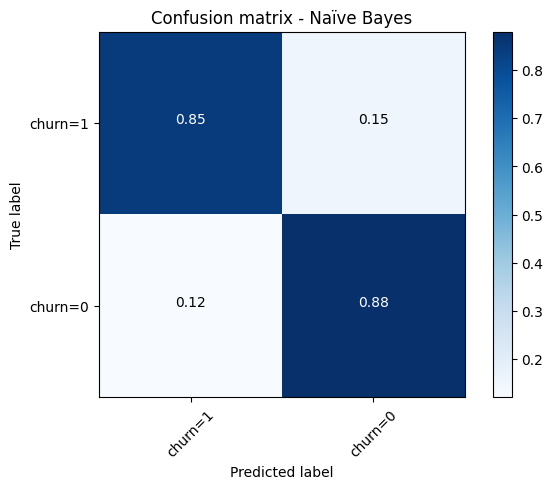

In [69]:
## confusion matrix ##
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test,yhat_nb, labels=[1,0]))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,yhat_nb, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= True,  title='Confusion matrix - Naïve Bayes')

## **Conclusion**

In [70]:
# best model  : Logistic Regression (Accuracy - 89.9%)